# Heart Disease Machine Learning Project.

**Problem Definition**
### A project aimed at modelling heart disease based on biometric factors in order to predict its incidence.
 * labels are binary 0(no heart disease) and 1(heart disease)
    
**Data**
Taken from Kaggle.com, this data set is curated by UCI in Cleveland
https://www.kaggle.com/ronitf/heart-disease-uci

*Evaluation:
With only 303 rows, this is a small dataset,but the spread between target labels 0(no heart disease) and 1(heart disease) is fairly even.
Also, with 14 columns there is a lot of depth to analyze our dataset with.

Our benchmark goal will be 95% accuracy  
    
**Features**
* age 
* sex
* chest pain type (4 values)(cp)
    - 0 = typical angina (chest pain related to lack of blood in heart)
    - 1 = Atypical angina (chest pain not related to heart)
    - 2 = non-anginal pain (typical esophageal spasm not related to heart)
    - 4 = Asymptomatic  
* resting blood pressure (trestbps)
    - one of the key risk factors outlined by the CDC)
    - Over 120 is cause for concern
* serum cholestoral in mg/dl (chol)
    - Another key CDC risk factor 
    - Over 200 is high and over 240 is irregular
* fasting blood sugar > 120 mg/dl (fbs)
    - high blood sugar can damage blood vessels and the nerves that control your heart
    - Over 200 is irregular
* resting electrocardiographic results (values 0,1,2) (restecg)
    - can tell where the heart's blood supply is blocked or interrupted by a build-up of fatty substances.
    - Over 100 is irregular
    - 0  = No signs of irregularity
    - 1 = ST-T wave abnormality (signals non-normal heart beat)
    - 2 = definite sign of left-ventricular hypertrophy
* maximum heart rate achieved (thalach)
    - 220 minus age is the threshold
* exercise induced angina
    - heart pain based on exercies
* oldpeak = ST depression induced by exercise relative to rest
* slope =the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy (ca)
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [8]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Data Exploration (EDA)

#### In this phase we want to learn as much about the data set as possible and become a subject matter expert.
* What are the questions and goals of the research
* What is the data like? 
* Are there relationships between features?
* Is there a missing component to the data?
* Are there outliers? Are they worth keeping?
* Do any features need augmentation, removal, etc?




In [9]:
df = pd.read_csv('heart-disease.csv')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
#more detail about target distribution
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [11]:
# Are there null values
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

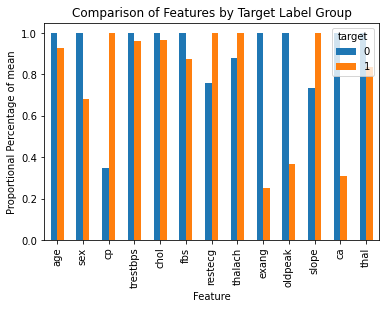

In [25]:
# It looks clean. Let's look at the rough relationship between target and features

target_breakdown = df.groupby('target').mean()

for column in target_breakdown.columns:
    target_breakdown[column] = target_breakdown[column]/target_breakdown[column].max()
transposed_for_graph = target_breakdown.T
transposed_for_graph.plot.bar(title='Comparison of Features by Target Label Group', xlabel='Feature', 
                              ylabel='Proportional Percentage of mean')
plt.savefig('Feature-and-Label-Comparison.jpg')

##### There are some clear relationships between the target and features: oldpeak, ca, cp, sex, and slope in particular.
* Women are much more likely to have heart disease in this sample 
* Incidence of chest pain appears highly correlated to heart disease.
* Exang appears to be a sign of good health, as does the number of vessels colored by flouroscopy.
* High ECG, Slope and Maximum heart rate appear to be indicative of heart disease probability
* We can see that Several factors may simply be adding noise. Resting blood pressure, cholesterol and age may not be as correlated to the target labels, as odd as that may seem. 

At 13 features, we should have enough depth to discard the 3 that aren't as strongly correlated. Why would we not create a separate test group or drop out these features altogether? 

We have only seen one line of correlation. The features themselves could be correlated in ways that, together, they helped predict heart disease. We now have to see how all features correlate to all other features.

''

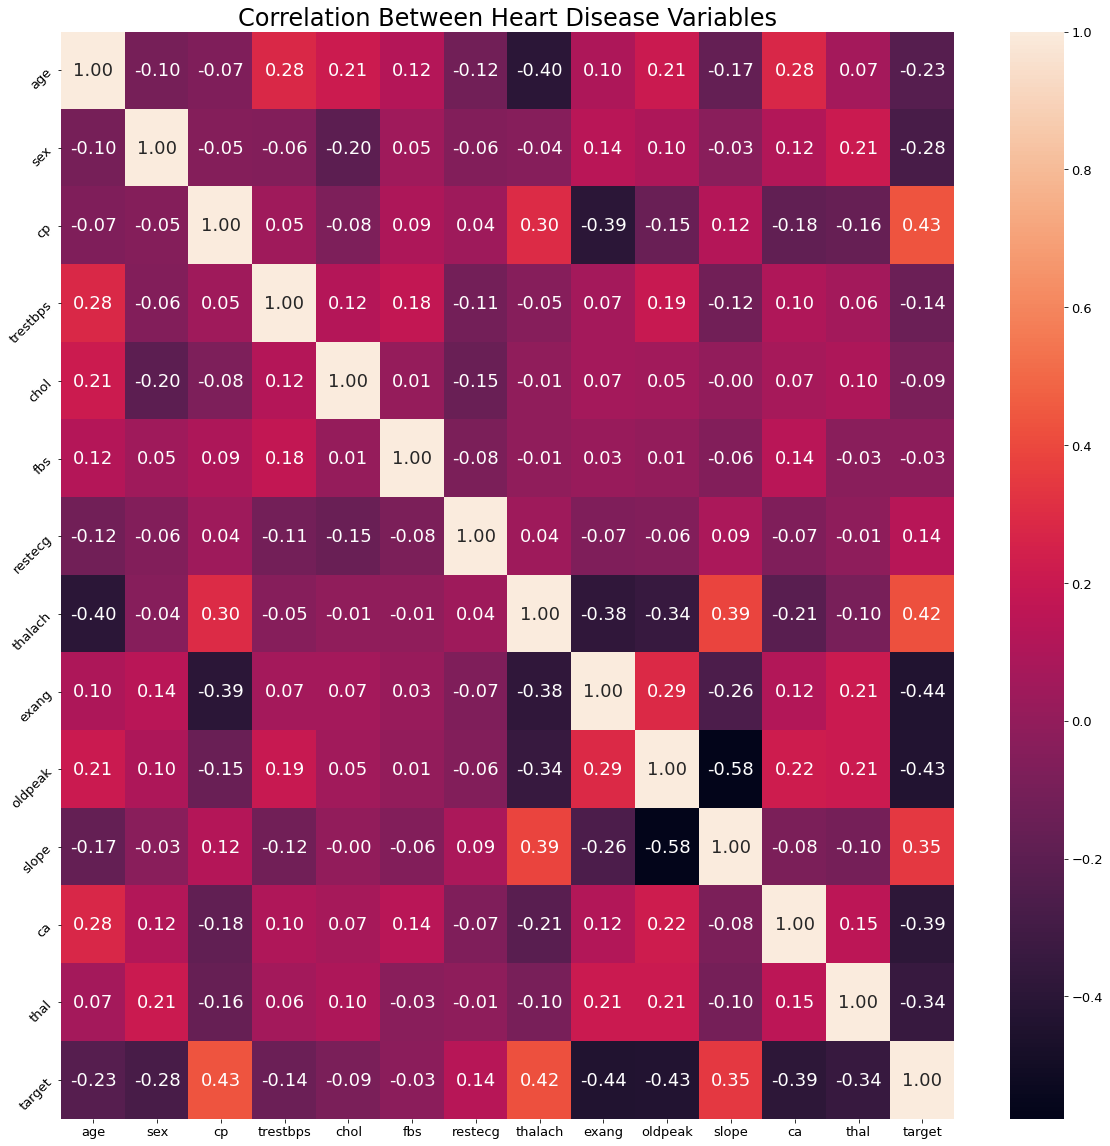

In [59]:
#Matrix of variable correlation
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
ax.set(title= 'Correlation Between Heart Disease Variables')
ax.set_yticklabels(ax.get_yticklabels(),rotation=45)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)
plt.savefig('Variable-Correlation-Matrix.jpg')
;

You can see that age has some of the highest correlation with cholesterol and resting blood pressure. 

It is possible that some combination of these factors will play a part in predicting heart disease.

It is also possible that a certain subset of the datapoints could be of interest, in a more limited scope that general correlation.

However, Machine makes it so easy to test this hypothesis. We will create a second test group without the three features which have the least correlation to our target label

In [60]:
## Modelling our Data

** We are going to do a preliminary run with 3 models 

In [14]:
X = df.drop('target', axis=1)
y = df['target']

test_group2 = df.drop(['age', 'chol', 'trestbps'], axis=1)
X2 = test_group2.drop('target', axis=1)
y2 = test_group2['target']

np.random.seed(42) # Enables reproducibility and consistency between models and tests.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)



In [24]:
y2_test.value_counts(), y_test.value_counts(), X_train[:3], X2_train[:3]

(0    32
 1    29
 Name: target, dtype: int64,
 1    32
 0    29
 Name: target, dtype: int64,
      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
 132   42    1   1       120   295    0        1      162      0      0.0   
 202   58    1   0       150   270    0        0      111      1      0.8   
 196   46    1   2       150   231    0        1      147      0      3.6   
 
      slope  ca  thal  
 132      2   0     2  
 202      2   0     3  
 196      1   0     2  ,
      sex  cp  fbs  restecg  thalach  exang  oldpeak  slope  ca  thal
 120    0   0    0        1      122      0      2.0      1   2     2
 223    0   0    1        0      133      1      4.0      0   2     3
 131    0   1    0        1      162      0      0.0      1   0     2)

They are not identical sets, but the label composition of the two test groups are similar, so we can assume our results will be comparable.


In [63]:
# For the function we will set up in the next cell, we need dictionaries of the models and the tests each will face
models_dict = {'KNeighbors': KNeighborsClassifier(),
              'RandomForest': RandomForestClassifier(),
              'LogisticRegression': LogisticRegression()}

C:\Users\fritz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\fritz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

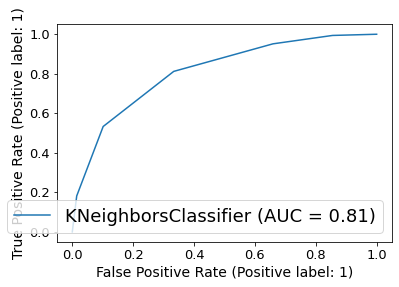

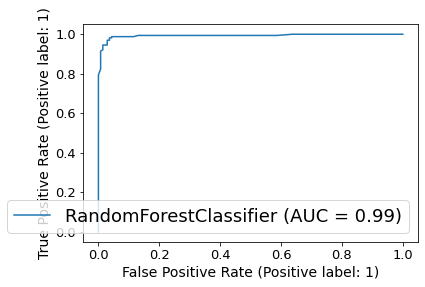

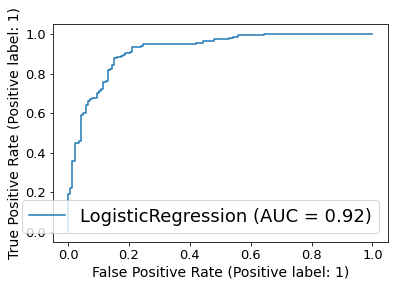

In [78]:
def model_test_results(X, y, X_train, X_test, y_train, y_test):
    """
    X: the complete set of feature data
    y: the complete set of target data
    X_train: feature labels for model training
    X_test: feature labels for model testing
    y_train: target labels for the training set
    y_test: target labels for the test set
    """
    test_result_repository = []
    for k, v in models_dict.items():

        v.fit(X_train, y_train)
        y_preds = v.predict(X_test)
        model_test ={
                     f'{k} accuracy_score':accuracy_score(y_test, y_preds),
                     f'{k} precision_score':precision_score(y_test, y_preds),
                     f'{k} recall_score': recall_score(y_test, y_preds),
                     f'{k} f1_score': f1_score(y_test, y_preds),
                     f'{k} confusion_matrix': confusion_matrix(y_test, y_preds),
                     f'{k} classification_report': classification_report(y_test, y_preds),
                     f'{k} plot_roc_curve': plot_roc_curve(v, X, y),
                     f'{k} cross_validate': cross_validate(v, X,y, cv=5,
                                                     scoring=['accuracy','recall', 'precision'])}
        model_test_copy = model_test.copy()
        test_result_repository.append(model_test_copy)
    return test_result_repository
results = model_test_results(X,y,X_train,X_test,y_train,y_test)


It looks like Random Forest and Logistic Regression far outperformed K Neighbor in terms of false positives. Let's see some of the other metrics we measured 

In [79]:
for k, v in results[0].items():
    print(k)
    print(v, '\n\n')
    

KNeighbors accuracy_score
0.6885245901639344 


KNeighbors precision_score
0.6857142857142857 


KNeighbors recall_score
0.75 


KNeighbors f1_score
0.7164179104477612 


KNeighbors confusion_matrix
[[18 11]
 [ 8 24]] 


KNeighbors classification_report
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        29
           1       0.69      0.75      0.72        32

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61
 


KNeighbors plot_roc_curve


KNeighbors cross_validate
{'fit_time': array([0.01563334, 0.        , 0.        , 0.        , 0.        ]), 'score_time': array([0.        , 0.01562977, 0.        , 0.01562905, 0.        ]), 'test_accuracy': array([0.60655738, 0.6557377 , 0.57377049, 0.73333333, 0.65      ]), 'test_recall': array([0.66666667, 0.72727273, 0.6969697 , 0.78787879, 0.72727273]), 'test_precision': array([0.

In [80]:
for k, v in results[1].items():
    print(k)
    print(v, '\n\n')

RandomForest accuracy_score
0.8524590163934426 


RandomForest precision_score
0.8484848484848485 


RandomForest recall_score
0.875 


RandomForest f1_score
0.8615384615384615 


RandomForest confusion_matrix
[[24  5]
 [ 4 28]] 


RandomForest classification_report
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61
 


RandomForest plot_roc_curve


RandomForest cross_validate
{'fit_time': array([0.12469149, 0.12491846, 0.12476373, 0.13698173, 0.1306653 ]), 'score_time': array([0.01880097, 0.01268744, 0.01030493, 0.0182178 , 0.01004601]), 'test_accuracy': array([0.83606557, 0.8852459 , 0.83606557, 0.8       , 0.76666667]), 'test_recall': array([0.90909091, 0.87878788, 0.84848485, 0.81818182, 0.87878788]), 'test_prec

In [81]:
for k, v in results[2].items():
    print(k)
    print(v, '\n\n')

LogisticRegression accuracy_score
0.8852459016393442 


LogisticRegression precision_score
0.8787878787878788 


LogisticRegression recall_score
0.90625 


LogisticRegression f1_score
0.8923076923076922 


LogisticRegression confusion_matrix
[[25  4]
 [ 3 29]] 


LogisticRegression classification_report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61
 


LogisticRegression plot_roc_curve


LogisticRegression cross_validate
{'fit_time': array([0.02212024, 0.02814007, 0.02210903, 0.02013564, 0.02564597]), 'score_time': array([0.        , 0.        , 0.01003885, 0.00802827, 0.01562691]), 'test_accuracy': array([0.81967213, 0.86885246, 0.81967213, 0.83333333, 0.75      ]), 'test_recall': array([0.90909091, 0.84848485

In [82]:
#### While it looks like Random Forest Classifier and Logistic Regression both performed well, Logistic Regression outperformed its counterpart in all measures, and was more consistent in the cross validation test.

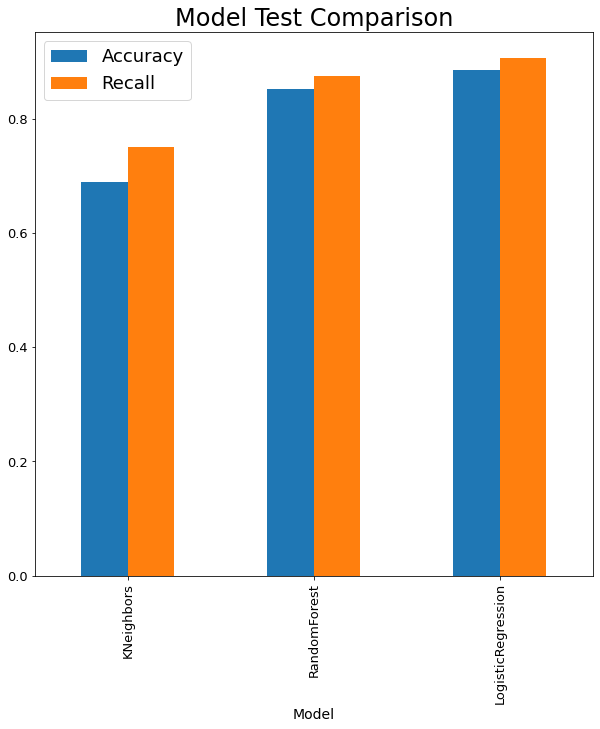

In [87]:
model_stats_plt = pd.DataFrame(data = [
                                       [results[0]['KNeighbors accuracy_score'],results[0]['KNeighbors recall_score']],
                                       [results[1]['RandomForest accuracy_score'], results[1]['RandomForest recall_score']],
                                       [results[2]['LogisticRegression accuracy_score'], results[2]['LogisticRegression recall_score']]
                                       ],
                               index=['KNeighbors', 'RandomForest', 'LogisticRegression'],
                               columns=['Accuracy', 'Recall'])
figure = model_stats_plt.plot.bar(figsize=(10,10), title='Model Test Comparison', xlabel='Model');

C:\Users\fritz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\fritz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

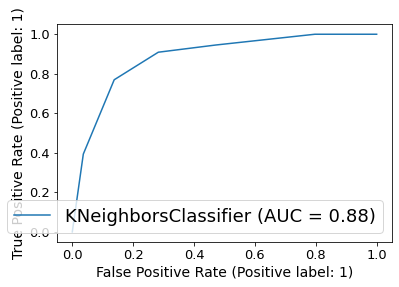

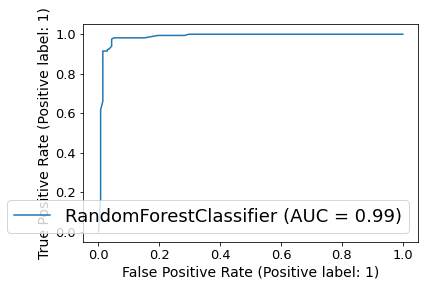

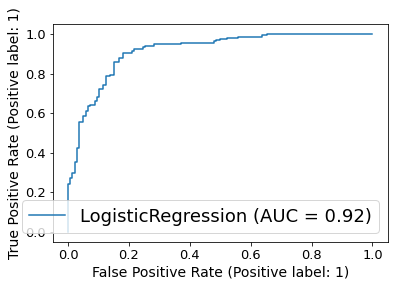

In [89]:
#We still have another test set. Luckily we can put the function we created before to quick use.

results2 = model_test_results(X2,y2, X2_train, X2_test, y2_train, y2_test)

In [90]:
# The ROC curves are almost identical, let's look closer at the data

for k, v in results2[0].items():
    print(k)
    print(v, '\n\n')

KNeighbors accuracy_score
0.7213114754098361 


KNeighbors precision_score
0.6666666666666666 


KNeighbors recall_score
0.8275862068965517 


KNeighbors f1_score
0.7384615384615385 


KNeighbors confusion_matrix
[[20 12]
 [ 5 24]] 


KNeighbors classification_report
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        32
           1       0.67      0.83      0.74        29

    accuracy                           0.72        61
   macro avg       0.73      0.73      0.72        61
weighted avg       0.74      0.72      0.72        61
 


KNeighbors plot_roc_curve


KNeighbors cross_validate
{'fit_time': array([0., 0., 0., 0., 0.]), 'score_time': array([0.01562786, 0.        , 0.01563001, 0.01050806, 0.        ]), 'test_accuracy': array([0.72131148, 0.78688525, 0.80327869, 0.8       , 0.71666667]), 'test_recall': array([0.84848485, 0.84848485, 0.90909091, 0.84848485, 0.81818182]), 'test_precision': array([0.7       , 0.77777778, 0.76

In [92]:
# KNeighbors seems to have improved. Let's see about RandomForest
for k, v in results2[1].items():
    print(k)
    print(v, '\n\n')

RandomForest accuracy_score
0.8360655737704918 


RandomForest precision_score
0.7878787878787878 


RandomForest recall_score
0.896551724137931 


RandomForest f1_score
0.8387096774193549 


RandomForest confusion_matrix
[[25  7]
 [ 3 26]] 


RandomForest classification_report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.79      0.90      0.84        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61
 


RandomForest plot_roc_curve


RandomForest cross_validate
{'fit_time': array([0.11591935, 0.14204335, 0.14093256, 0.12064171, 0.13288474]), 'score_time': array([0.01563334, 0.01006031, 0.02012038, 0.01808095, 0.01005793]), 'test_accuracy': array([0.85245902, 0.86885246, 0.80327869, 0.81666667, 0.81666667]), 'test_recall': array([0.90909091, 0.87878788, 0.78787879, 0.81818182, 0.87878788])

In [94]:
for k, v in results2[2].items():
    print(k)
    print(v, '\n\n')

LogisticRegression accuracy_score
0.8360655737704918 


LogisticRegression precision_score
0.7714285714285715 


LogisticRegression recall_score
0.9310344827586207 


LogisticRegression f1_score
0.8437500000000001 


LogisticRegression confusion_matrix
[[24  8]
 [ 2 27]] 


LogisticRegression classification_report
              precision    recall  f1-score   support

           0       0.92      0.75      0.83        32
           1       0.77      0.93      0.84        29

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61
 


LogisticRegression plot_roc_curve


LogisticRegression cross_validate
{'fit_time': array([0.02011418, 0.02821088, 0.02811551, 0.0201478 , 0.03020191]), 'score_time': array([0.        , 0.0020287 , 0.00201488, 0.        , 0.01007032]), 'test_accuracy': array([0.85245902, 0.8852459 , 0.85245902, 0.9       , 0.73333333]), 'test_recall': array([0.93939394,

The results are a wash, with slight decrease in performance. One point of interest is that in all models, the percentage of false negatives dropped, and recalls rose despite this decrease. The recall scores showed a 8%, 2% and 2% increase for K Neighbor, Random Forest, and Logistic Regression models respectively. 

The implication is significant. If we could test for general accuracy with one test, and then test negatives again with a model that excels in picking out false negatives, we could reduce the risk of error.

Since our first test group outperformed in most measures, lets focus on hyper parameter tuning on this data set first.
We will only be using Logistic Regression and Random Forest Models from here on out.

In [138]:
random_forest_grid = {'n_estimators': np.arange(10,1000,50),
                     'max_depth':[None,1,2,4,10],
                     'min_samples_split': np.arange(2,10,1),
                     'min_samples_leaf': np.arange(2,10,1)}
logistic_regression_grid = {'C':np.logspace(-4, 4,20),
                           'solver': ['liblinear']}
#Random Forest object
rfc = RandomForestClassifier()
#Logistic Regression Object
lrc = LogisticRegression()

#Randomized Search for Random Forest
rf_RandomizedSearchCV = RandomizedSearchCV(rfc, random_forest_grid, cv=5, verbose=True, n_iter=20)
# This does not even cover .01& of the possible combinations

#Randomized Search for Logistic Regression
lrc_RandomizedSearchCV = RandomizedSearchCV(lrc, logistic_regression_grid, cv=5, verbose=True, n_iter=20)
# For the logistic regression grid, 20 tests will exhaust all possibilities

In [128]:
np.random.seed(42)
lrc_RandomizedSearchCV.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [129]:
lrc_RandomizedSearchCV.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [131]:
lrc_RandomizedSearchCV.score(X_test, y_test)

0.8852459016393442

In [139]:
np.random.seed(42)
rf_RandomizedSearchCV.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 1, 2, 4, 10],
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [140]:
rf_RandomizedSearchCV.best_params_

{'n_estimators': 960,
 'min_samples_split': 3,
 'min_samples_leaf': 4,
 'max_depth': 2}

In [141]:
rf_RandomizedSearchCV.score(X_test, y_test)

0.8688524590163934

Both have not changed significantly between the SearchCV iterations and their baseline scores. Also, despite Random Forest seeing much more variation in hyperparameters, it is still below the accuracy of the Logistic Regression model.